In [4]:
import torch
import pyro
import pyro.distributions as dist

pyro.set_rng_seed(101)


<div id="introduction-to-pyro" class="section level2">
<h2><span class="header-section-number">4.2</span> Introduction to Pyro</h2>
<p>Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.</p>
<p>Our purpose of this class, pyro has “do”-operator that allows intervention and counterfactual inference in these probabilistic models.</p>
<div id="stochastic-functions" class="section level3">
<h3><span class="header-section-number">4.2.1</span> Stochastic Functions</h3>
<p>The basic unit of probabilistic programs is the stochastic function. A stochastic function is an arbitrary Python callable that combines two ingredients:</p>
<ul>
<li>deterministic Python code; and</li>
<li>primitive stochastic functions that call a random number generator</li>
</ul>
<p>For this course, we will consider these stochastic functions as <strong>models</strong>. Stochastic functions can be used to represent simplified or abstract descriptions of a data-generating process.</p>
</div>
<div id="primitive-stochastic-functions" class="section level3">
<h3><span class="header-section-number">4.2.2</span> Primitive stochastic functions</h3>
<p>We call them distributions. We can explicitly compute the probability of the outputs given the inputs.</p>

In [2]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample: ", x)

sample:  tensor(-1.3905)


Pyro simplifies this process of sampling from distributions. It uses pyro.sample().

In [3]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-0.8152)


<p>Just like a direct call to <code>torch.distributions.Normal().rsample()</code>, this returns a sample from the unit normal distribution. The crucial difference is that this sample is named. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. This is how Pyro can implement the various manipulations that underlie inference algorithms.</p>
<p>Let’s write a simple <code>weather</code> model.</p>

<h3><span class="header-section-number">4.2.3</span> A simple model</h3>

In [5]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()
for _ in range(3):
    print(weather())

('cloudy', 51.373016357421875)
('cloudy', 52.28388595581055)
('sunny', 70.28937530517578)


<p>First two lines introduce a binary variable <code>cloudy</code>, which is given by a draw from the Bernoulli distribution with a parameter of <span class="math inline">\(0.3\)</span>. The Bernoulli distribution returns either <span class="math inline">\(0\)</span> or <span class="math inline">\(1\)</span>, line <code>2</code> converts that into a string. So, So according to this model, <span class="math inline">\(30%\)</span> of the time it’s cloudy and <span class="math inline">\(70%\)</span> of the time it’s sunny.</p>
<p>In line <code>4</code> and <code>5</code>, we initialize mean and scale of the temperature for both values. We then sample, the temperature from a Normal distribution and return that along with <code>cloudy</code> variable.</p>
<p>We can build complex model by modularizing and reusing the concepts into functions and use them as programmers use functions.</p>

In [6]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

<h2><span class="header-section-number">4.3</span> Inference</h2>
<p>As we discussed earlier, the reason we use PPLs is because they can easily go backwards and reason about cause given the observed effect. There are myriad of inference algorithms available in pyro. Let’s try it on an even simpler model.</p>

In [7]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement
scale(5.)

tensor(2.9213)

<p>Suppose we observe that the <code>measurement</code> of an object was <span class="math inline">\(14\)</span> lbs. What would have we guessed if we tried to guess it’s <code>weight</code> first?</p>
<p>This question is answered in two steps.</p>
<ol style="list-style-type: decimal">
<li>Condition the model.</li>
</ol>

In [8]:
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(14.)})

<ol start="2" style="list-style-type: decimal">
<li>Set the prior and infer the posterior. We will use</li>
</ol>

In [9]:
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC
from pyro.infer import EmpiricalMarginal
import matplotlib.pyplot as plt
# %matplotlib inline
guess_prior = 10.
hmc_kernel = HMC(conditioned_scale, step_size=0.9, num_steps=4)
posterior = MCMC(hmc_kernel, num_samples=1000, warmup_steps=50).run(guess_prior)

Sample: 100%|██████████| 1050/1050 [00:04<00:00, 262.34it/s, step size=1.31e+00, acc. rate=0.930]


Text(0, 0.5, '#')

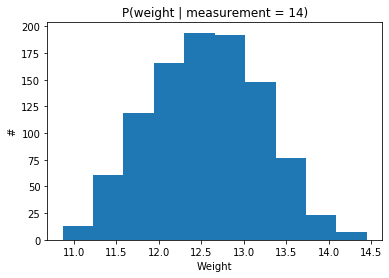

In [10]:
marginal = EmpiricalMarginal(posterior, "weight")
plt.hist([marginal().item() for _ in range(1000)],)
plt.title("P(weight | measurement = 14)")
plt.xlabel("Weight")
plt.ylabel("#")

<h4><span class="header-section-number">4.3.0.1</span> Shapes in distribution:</h4>
<p>We know that PyTorch tensor have single <code>shape</code> attribute, <code>Distribution</code>s have two shape attributes with special meaning. * <code>.batch_shape</code>: Indices over <code>.batch_shape</code> denote conditionally independent random variables, * <code>.event_shape</code>: indices over <code>.event_shape</code> denote dependent random variables (ie one draw from a distribution).</p>
<p>These two combine to define the total shape of a sample. Thus the total shape of <code>.log_prob()</code> of distribution is <code>.batch_shape</code>.</p>
<p>Also, <code>Distribution.sample()</code> also has a <code>sample_shape</code> attribute that indexes over independent and identically distributed(iid) random variables.</p>


<pre><code>      |      iid     | independent | dependent
------+--------------+-------------+------------
shape = sample_shape + batch_shape + event_shape</code></pre>
<p>To know more about + , go through <a href="https://pytorch.org/docs/master/notes/broadcasting.html">broadcasting tensors in PyTorch</a>.</p>

<h3><span class="header-section-number">4.3.1</span> Examples</h3>
<p>One way to introduce batch_shape is use <code>expand</code>.</p>

In [11]:
d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3, 3)).expand([5]) # expand - 3 of these Multivariate Normal Dists
print("batch_shape: ", d.batch_shape)

batch_shape:  torch.Size([5])


In [12]:
print("event_shape: ", d.event_shape)

event_shape:  torch.Size([3])


In [13]:
x = d.sample()
print("x shape: ", x.shape)          # == sample_shape + batch_shape + event_shape

x shape:  torch.Size([5, 3])


In [14]:
print("d.log_prob(x) shape:", d.log_prob(x).shape)  # == batch_shape

d.log_prob(x) shape: torch.Size([5])


<p>The other way is using <code>plate</code> context manager.</p>
<p>Pyro models can use the context manager <code>pyro.plate</code> to declare that certain batch dimensions are independent. Inference algorithms can then take advantage of this independence to e.g. construct lower variance gradient estimators or to enumerate in linear space rather than exponential space.</p>

In [16]:
with pyro.plate("x_axis", 5):
    d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3, 3))
    x = pyro.sample("x", d)

x.shape

torch.Size([5, 3])

<p>In fact, we can also nest <code>plates</code>. The only thing we need to care about is, which dimensions are independent. Pyro automatically manages this but sometimes we need to explicitely specify the dimensions. Once we specify that, we can leverage PyTorch’s CUDA enabled capabilities to run inference on GPUs.</p>

In [17]:
with pyro.plate("x_axis", 320):
    # within this context, batch dimension -1 is independent
    with pyro.plate("y_axis", 200):
        # within this context, batch dimensions -2 and -1 are independent

SyntaxError: unexpected EOF while parsing (<ipython-input-17-c756cd874096>, line 4)

<p>Note that we always count from the right by using negative indices like <span class="math inline">\(-2\)</span>, <span class="math inline">\(-1\)</span>.</p>